In [1]:
pip install pygrib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

# Open GRIB file
grbs = pygrib.open('/home/emine2/CPSC-499/data/data_iowa_monthlyAvg.grib')


In [2]:

# 1) Inspect parameters to find a temperature-related one
print("Inspecting GRIB file contents:")
grbs.seek(0)
for i, grb in enumerate(grbs):
    print(f"Message {i+1}: {grb.name} ({grb.shortName}), Date: {grb.validDate}, Shape: {grb.values.shape}")

Inspecting GRIB file contents:
Message 1: 2 metre temperature (2t), Date: 2008-01-01 00:00:00, Shape: (13, 26)
Message 2: Total precipitation (tp), Date: 2007-12-31 18:00:00, Shape: (13, 26)
Message 3: 2 metre temperature (2t), Date: 2008-02-01 00:00:00, Shape: (13, 26)
Message 4: Total precipitation (tp), Date: 2008-01-31 18:00:00, Shape: (13, 26)
Message 5: 2 metre temperature (2t), Date: 2008-03-01 00:00:00, Shape: (13, 26)
Message 6: Total precipitation (tp), Date: 2008-02-29 18:00:00, Shape: (13, 26)
Message 7: 2 metre temperature (2t), Date: 2008-04-01 00:00:00, Shape: (13, 26)
Message 8: Total precipitation (tp), Date: 2008-03-31 18:00:00, Shape: (13, 26)
Message 9: 2 metre temperature (2t), Date: 2008-05-01 00:00:00, Shape: (13, 26)
Message 10: Total precipitation (tp), Date: 2008-04-30 18:00:00, Shape: (13, 26)
Message 11: 2 metre temperature (2t), Date: 2008-06-01 00:00:00, Shape: (13, 26)
Message 12: Total precipitation (tp), Date: 2008-05-31 18:00:00, Shape: (13, 26)
Messag

In [2]:
# 1) Inspect the GRIB file by iterating through messages
print("Inspecting GRIB file contents:")
for i, grb in enumerate(grbs):
    # Print metadata for each message
    print(f"\nMessage {i+1}:")
    print(f"  Parameter: {grb.name} ({grb.shortName})")
    print(f"  Units: {grb.units}")
    print(f"  Level: {grb.level} {grb.typeOfLevel}")
    print(f"  Date: {grb.validDate}")
    print(f"  Shape of data: {grb.values.shape}")
    
    # Extract lat/lon grids
    lats, lons = grb.latlons()
    print(f"  Latitude range: {lats.min():.2f} to {lats.max():.2f}")
    print(f"  Longitude range: {lons.min():.2f} to {lons.max():.2f}")



Inspecting GRIB file contents:

Message 1:
  Parameter: 2 metre temperature (2t)
  Units: K
  Level: 0 surface
  Date: 2008-01-01 00:00:00
  Shape of data: (13, 26)
  Latitude range: 40.37 to 43.37
  Longitude range: -96.60 to -90.35

Message 2:
  Parameter: Total precipitation (tp)
  Units: m
  Level: 0 surface
  Date: 2007-12-31 18:00:00
  Shape of data: (13, 26)
  Latitude range: 40.37 to 43.37
  Longitude range: -96.60 to -90.35

Message 3:
  Parameter: 2 metre temperature (2t)
  Units: K
  Level: 0 surface
  Date: 2008-02-01 00:00:00
  Shape of data: (13, 26)
  Latitude range: 40.37 to 43.37
  Longitude range: -96.60 to -90.35

Message 4:
  Parameter: Total precipitation (tp)
  Units: m
  Level: 0 surface
  Date: 2008-01-31 18:00:00
  Shape of data: (13, 26)
  Latitude range: 40.37 to 43.37
  Longitude range: -96.60 to -90.35

Message 5:
  Parameter: 2 metre temperature (2t)
  Units: K
  Level: 0 surface
  Date: 2008-03-01 00:00:00
  Shape of data: (13, 26)
  Latitude range: 40.37

In [3]:
# 2) Example: Extract and plot a time series (if applicable)
# Reset file pointer to start
grbs.seek(0)

# Collect data for a specific parameter (e.g., temperature)
times = []
values = []
for grb in grbs:
    if grb.shortName == "2t":  # 2m temperature
        times.append(grb.validDate)
        # Take the mean over the spatial dimensions for a time series
        values.append(np.mean(grb.values))


Time series plot saved as 'temperature_time_series.png'


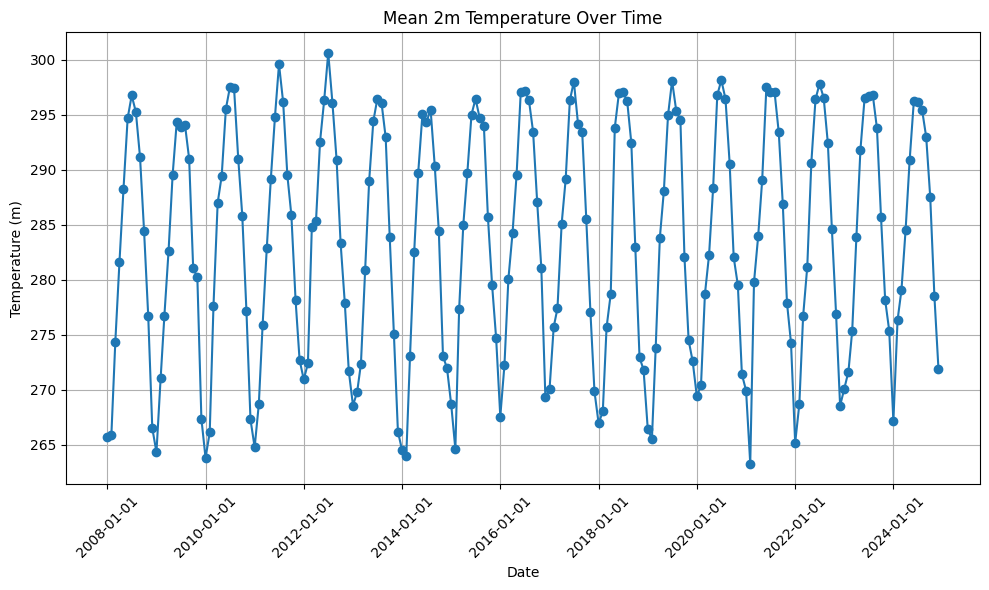

In [4]:
# 3) Plot the time series
if times and values:
    plt.figure(figsize=(10, 6))
    plt.plot(times, values, marker='o', linestyle='-')
    plt.title("Mean 2m Temperature Over Time")
    plt.xlabel("Date")
    plt.ylabel(f"Temperature ({grb.units})")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("temperature_time_series.png")
    print("Time series plot saved as 'temperature_time_series.png'")
else:
    print("No 2m temperature data found for plotting.")

# Close the GRIB file
grbs.close()

: 

In [4]:

# 2) Process and save data incrementally
grbs.seek(0)
first_write = True  # To control CSV header writing
for i, grb in enumerate(grbs):
    # Look for temperature-related data
    if "temperature" in grb.name.lower():
        print(f"\nProcessing Message {i+1}: {grb.name} ({grb.shortName})")

        # Extract lat/lon grids and values
        lats, lons = grb.latlons()
        values = grb.values
        time = grb.validDate

        # Get the shape of the data
        ny, nx = values.shape
        # Create arrays for the DataFrame
        data = {
            "time": np.repeat(time, ny * nx),
            "latitude": lats.flatten(),
            "longitude": lons.flatten(),
            "temperature_K": values.flatten()
        }

        # Create a small DataFrame for this message
        df = pd.DataFrame(data)

        # Append to CSV incrementally
        if first_write:
            df.to_csv("/home/emine2/CPSC-499/data/grib_temperature_iowa.csv", index=False, mode='w')
            first_write = False
        else:
            df.to_csv("grib_temperature.csv", index=False, mode='a', header=False)

        # Clear memory
        del df, data
        print(f"Message {i+1} saved to CSV")



Processing Message 1: 2 metre temperature (2t)
Message 1 saved to CSV

Processing Message 3: 2 metre temperature (2t)
Message 3 saved to CSV

Processing Message 5: 2 metre temperature (2t)
Message 5 saved to CSV

Processing Message 7: 2 metre temperature (2t)
Message 7 saved to CSV

Processing Message 9: 2 metre temperature (2t)
Message 9 saved to CSV

Processing Message 11: 2 metre temperature (2t)
Message 11 saved to CSV

Processing Message 13: 2 metre temperature (2t)
Message 13 saved to CSV

Processing Message 15: 2 metre temperature (2t)
Message 15 saved to CSV

Processing Message 17: 2 metre temperature (2t)
Message 17 saved to CSV

Processing Message 19: 2 metre temperature (2t)
Message 19 saved to CSV

Processing Message 21: 2 metre temperature (2t)
Message 21 saved to CSV

Processing Message 23: 2 metre temperature (2t)
Message 23 saved to CSV

Processing Message 25: 2 metre temperature (2t)
Message 25 saved to CSV

Processing Message 27: 2 metre temperature (2t)
Message 27 s

In [ ]:
# 3) Final message
if not first_write:
    print("Data saved to 'grib_temperature.csv'")
else:
    print("No temperature data found to save.")

# Close the GRIB file
grbs.close()

Data saved to 'grib_temperature.csv'


In [5]:
import pygrib
import pandas as pd
import numpy as np

# Open GRIB file
grbs = pygrib.open('/home/emine2/CPSC-499/data/data.grib')

# 1) Inspect parameters to confirm availability of total precipitation
print("Inspecting GRIB file contents:")
grbs.seek(0)
for i, grb in enumerate(grbs):
    print(f"Message {i+1}: {grb.name} ({grb.shortName}), Date: {grb.validDate}, Shape: {grb.values.shape}")

# 2) Process and save total precipitation data incrementally
grbs.seek(0)
first_write = True  # To control CSV header writing
for i, grb in enumerate(grbs):
    # Look for total precipitation (tp)
    if grb.shortName == "tp":
        print(f"\nProcessing Message {i+1}: {grb.name} ({grb.shortName})")

        # Extract lat/lon grids and values
        lats, lons = grb.latlons()
        values = grb.values
        time = grb.validDate

        # Get the shape of the data
        ny, nx = values.shape
        # Create arrays for the DataFrame
        data = {
            "time": np.repeat(time, ny * nx),
            "latitude": lats.flatten(),
            "longitude": lons.flatten(),
            "total_precipitation_m": values.flatten()  # Units typically in meters
        }

        # Create a small DataFrame for this message
        df = pd.DataFrame(data)

        # Append to CSV incrementally
        if first_write:
            df.to_csv("/home/emine2/CPSC-499/data/grib_precipitation_iowa.csv", index=False, mode='w')
            first_write = False
        else:
            df.to_csv("/home/emine2/CPSC-499/data/grib_precipitation_iowa.csv", index=False, mode='a', header=False)

        # Clear memory
        del df, data
        print(f"Message {i+1} saved to CSV")

# 3) Final message
if not first_write:
    print("Data saved to 'grib_total_precipitation.csv'")
else:
    print("No total precipitation data found to save.")

# Close the GRIB file
grbs.close()

Inspecting GRIB file contents:
Message 1: 2 metre temperature (2t), Date: 2008-01-01 00:00:00, Shape: (23, 17)
Message 2: Total precipitation (tp), Date: 2007-12-31 18:00:00, Shape: (23, 17)
Message 3: 2 metre temperature (2t), Date: 2008-02-01 00:00:00, Shape: (23, 17)
Message 4: Total precipitation (tp), Date: 2008-01-31 18:00:00, Shape: (23, 17)
Message 5: 2 metre temperature (2t), Date: 2008-03-01 00:00:00, Shape: (23, 17)
Message 6: Total precipitation (tp), Date: 2008-02-29 18:00:00, Shape: (23, 17)
Message 7: 2 metre temperature (2t), Date: 2008-04-01 00:00:00, Shape: (23, 17)
Message 8: Total precipitation (tp), Date: 2008-03-31 18:00:00, Shape: (23, 17)
Message 9: 2 metre temperature (2t), Date: 2008-05-01 00:00:00, Shape: (23, 17)
Message 10: Total precipitation (tp), Date: 2008-04-30 18:00:00, Shape: (23, 17)
Message 11: 2 metre temperature (2t), Date: 2008-06-01 00:00:00, Shape: (23, 17)
Message 12: Total precipitation (tp), Date: 2008-05-31 18:00:00, Shape: (23, 17)
Messag